# 感知机

感知机是一个二分类模型

输入向量x 权重向量w 偏移标量b

σ(x) = 1 if x > 0 else 0

输出标量o = σ(<x, w> + b)

# 多层感知机

## 二分类

输入层x(n维) 隐藏层h(n->m->1) 输出层o(1维)

隐藏层的大小 m 是超参数

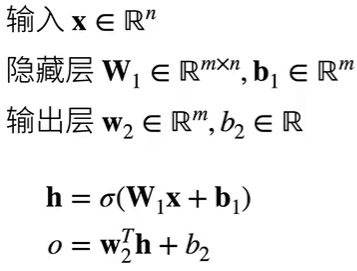

（σ是非线性的激活函数）

σ可以选取sigmoid tanh ReLU

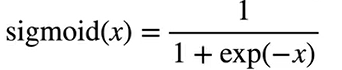
(0, 1)

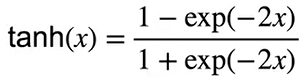
(-1, 1)

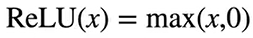
[0, ∞) 用的多，因为消耗小，指数运算很贵

## 多分类

输入层x(n维) 隐藏层h(n->m->k) 输出层o(k维)

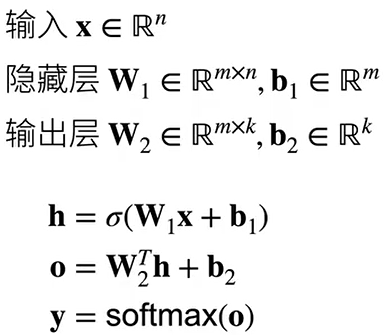

## 多隐藏层

超参数：隐藏层数 每层隐藏层的大小

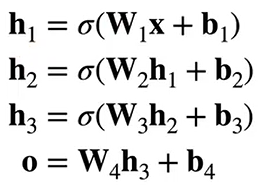

常见隐藏层大小设置策略：第一层可以比输入层大，之后每层大小递减

# 多层感知机实现

数据集 参数

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

# 初始化批量大小 加载数据集
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

# 输入层 输出层 单隐藏层
num_inputs, num_outputs, num_hiddens = 784, 10, 256

# 初始化参数（权重 偏移）
W1 = nn.Parameter(torch.randn(num_inputs, num_hiddens, requires_grad=True) * 0.01)
b1 = nn.Parameter(torch.zeros(num_hiddens, requires_grad=True))
W2 = nn.Parameter(torch.randn(num_hiddens, num_outputs, requires_grad=True) * 0.01)
b2 = nn.Parameter(torch.zeros(num_outputs, requires_grad=True))
params = [W1, b1, W2, b2]

模型 损失

In [2]:
def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X, a)

def net(X):
    X = X.reshape((-1, num_inputs))
    H = relu(X @ W1 + b1)  # @ 表示矩阵乘法
    O = (H @ W2 + b2)
    return O

loss = nn.CrossEntropyLoss()

训练

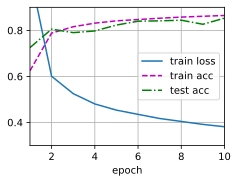

In [3]:
num_epochs = 10
lr = 0.1
updater = torch.optim.SGD(params, lr=lr)

def accuracy(y_hat, y):
    """计算预测正确的数量"""
    if (len(y_hat.shape) > 1 and y_hat.shape[1] > 1):
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())
def evaluate_accuracy(net, data_iter):
    """计算指定数据集上模型的精度"""
    if(isinstance(net, torch.nn.Module)):
        net.eval()  # 模型设置为评估模式
    metric = d2l.Accumulator(2)  # 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]
def train_epoch(net, train_iter, loss, updater):
    if isinstance(net, torch.nn.Module):
        net.train()
    metric = d2l.Accumulator(3)
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            updater.step()
            metric.add(float(l) * len(y), d2l.accuracy(y_hat, y), y.size().numel())
        else:
            l.sum().backward()
            updater(X.shape[0])
            metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]
def train(net, train_iter, test_iter, loss, num_epochs, updater):
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

train(net, train_iter, test_iter, loss, num_epochs, updater)

简洁实现

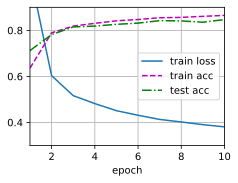

In [7]:
import torch
from torch import nn
from d2l import torch as d2l

net = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
)

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)
net.apply(init_weights)

batch_size = 256
lr = 0.1
num_epochs = 10
loss = nn.CrossEntropyLoss()
trainer = torch.optim.SGD(net.parameters(), lr)

train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
train(net, train_iter, test_iter, loss, num_epochs, trainer)